## QC

In [2]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [3]:
import os

os.environ['PYTHONHASHSEED'] = '0'

## Low quality cell filtering

In [4]:
def check_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [5]:
def mt_genes(adata):
    # Filter out the mitochondrial outliers
    mt_outliers = adata[adata.obs['mt_outlier']]

    # Identify mitochondrial genes
    mito_genes = [gene for gene in adata.var_names if gene.startswith('MT-')]

    # Calculate the average expression of mitochondrial genes in outliers
    mt_outlier_expression = mt_outliers[:, mito_genes].X.toarray()
    average_expression = np.mean(mt_outlier_expression, axis=0)

    # Create a DataFrame to sort the genes by average expression
    mt_expression_df = pd.DataFrame({
        'gene': mito_genes,
        'average_expression': average_expression
    })

    # Sort the DataFrame by average expression
    mt_expression_df_sorted = mt_expression_df.sort_values(by='average_expression', ascending=False)

    # Retrieve the top most highly expressed mitochondrial genes
    top_mito_genes = mt_expression_df_sorted.head()

    print(top_mito_genes)

In [6]:
def filtering(adata,sample):
    
    np.random.seed(0)
    
    adata.var_names_make_unique()
    
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
    )
    
    p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
    # sc.pl.violin(adata, 'total_counts')
    p2 = sc.pl.violin(adata, "pct_counts_mt")
    p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
    
    #print(np.median(adata.obs["total_counts"]))
    #print(np.median(adata.obs["n_genes_by_counts"]))
    #print(np.median(adata.obs["pct_counts_in_top_20_genes"]))
    adata.obs["outlier"] = (
        check_outlier(adata, "log1p_total_counts", 5)
        | check_outlier(adata, "log1p_n_genes_by_counts", 5)
        | check_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    print(adata.obs.outlier.value_counts())
    
    #adata.obs["mt_outlier"] = check_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 20)
    adata.obs["mt_outlier"] = check_outlier(adata, "pct_counts_mt", 5) | (adata.obs["pct_counts_mt"] > 20)

    adata.obs.mt_outlier.value_counts()
    
    is_outlier = []
    for i in range(adata.obs.shape[0]):
        is_outlier.append(max(adata.obs.outlier[i],adata.obs.mt_outlier[i]))
      
    adata.obs["is_outlier"] = is_outlier
    
    # Define dot size for all plot parts
    s=20
    # Plot all cells as background
    ax=sc.pl.scatter(adata, "n_genes_by_counts", "pct_counts_in_top_20_genes", show=False,size=s)
    # Plot ontop expression of a single cell group by subsetting adata
    p = sc.pl.scatter(adata[adata.obs.is_outlier==True,:], "n_genes_by_counts", "pct_counts_in_top_20_genes", color='pct_counts_mt',ax=ax,size=s)
    # Show the plots
    plt.show()
    
    adata.obs['sample']=sample
    
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color='is_outlier')
    
    print(f"Total number of cells: {adata.n_obs}")
    print(f"Total number of reads: {sum(adata.X.data)}")
    
    #adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    #adata = adata[~adata.obs.outlier].copy()

    print(f"Number of cells after filtering of low quality cells: {adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].n_obs}")
    print(f"Number of reads after filtering of low quality cells: {sum(adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].X.data)}")

    return adata
    

In [7]:
def violin_QC_plot(*adata_objects):
    
    obs_dataframes = []
    
    for adata in adata_objects:
        # Append the `obs` DataFrame to the list
        obs_dataframes.append(adata.obs)
    
    # Concatenate all `obs` dataframes
    concatenated_df = pd.concat(obs_dataframes)
    
    p = sns.violinplot(data=concatenated_df,x="sample",y="total_counts", cut=0, log_scale=True, hue="is_outlier", split=True,inner="quart")
    sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))
    

Sample 3B :

In [36]:
adata3B = sc.read_10x_h5(
    filename="sample_3B/filtered_feature_bc_matrix.h5")
adata3B

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 9873 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
sum(adata3B.X.data)
#scipy.sparse.csr_matrix.sum(adata3B.X) <- considers all elements, including zeros, so higher count

105800934.0

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


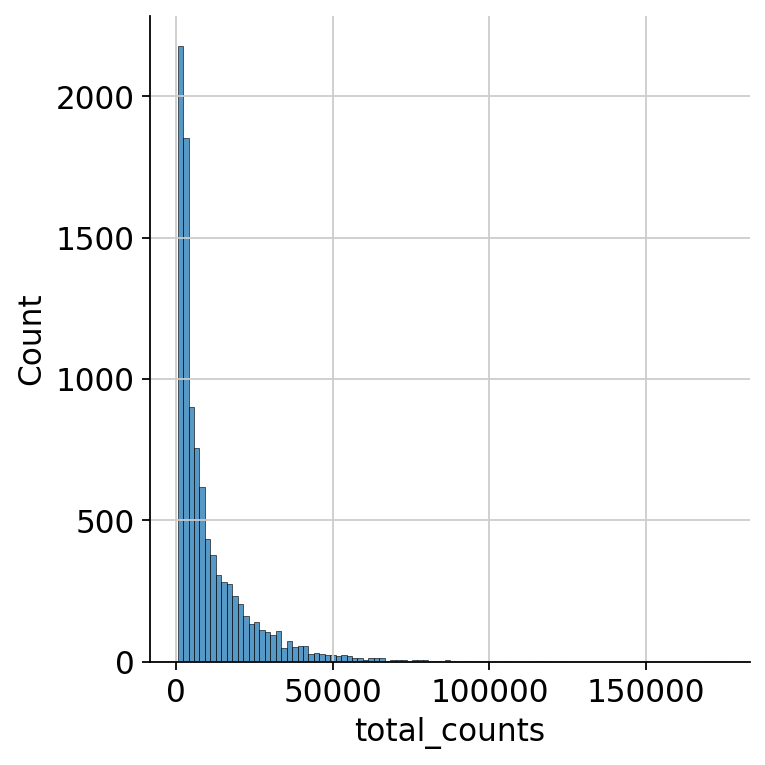

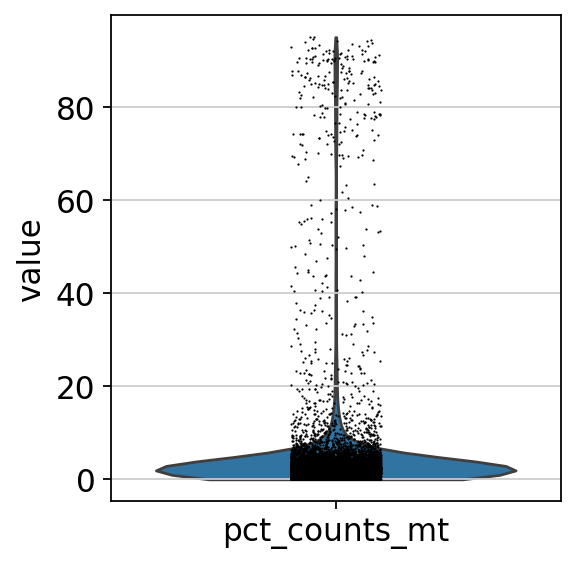

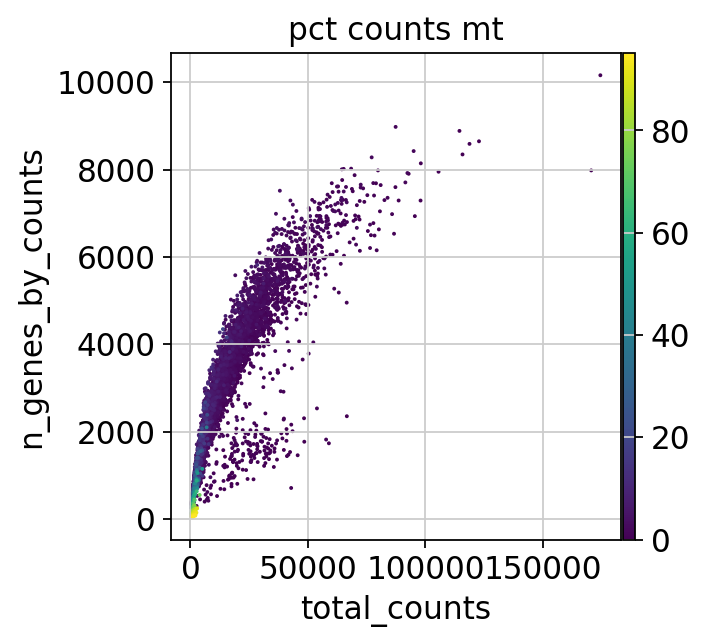

False    9324
True      549
Name: outlier, dtype: int64


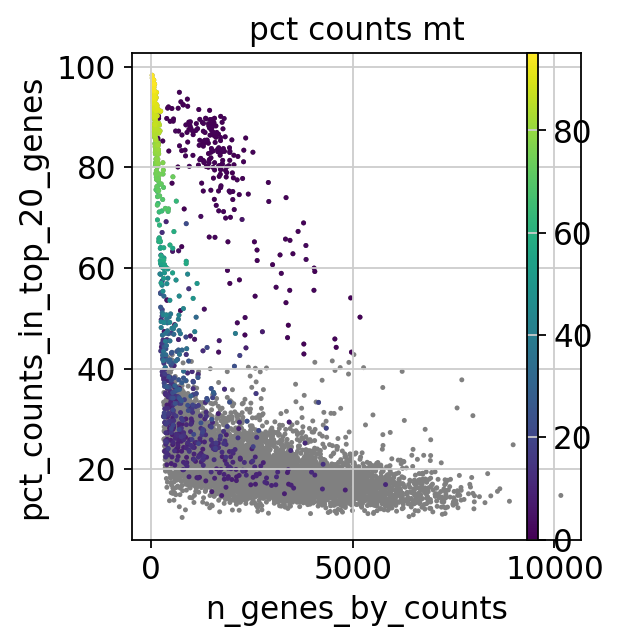

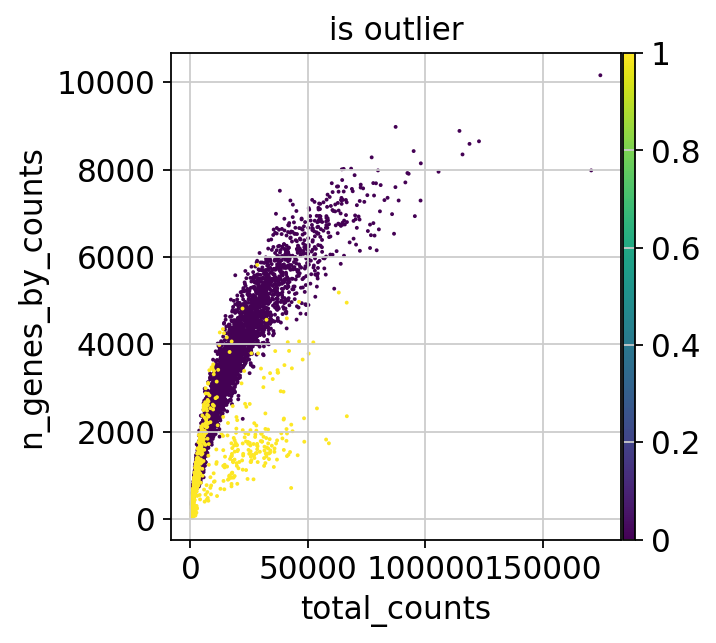

Total number of cells: 9873
Total number of reads: 105800934.0
Number of cells after filtering of low quality cells: 8933
Number of reads after filtering of low quality cells: 98690529.0


In [37]:
adata3B = filtering(adata3B,"3B")

Sample 26 :

In [6]:
adata26 = sc.read_10x_h5(
    filename="sample_26/filtered_feature_bc_matrix.h5")
adata26

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6667 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [11]:
sum(adata26.X.data)

69084588.0

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


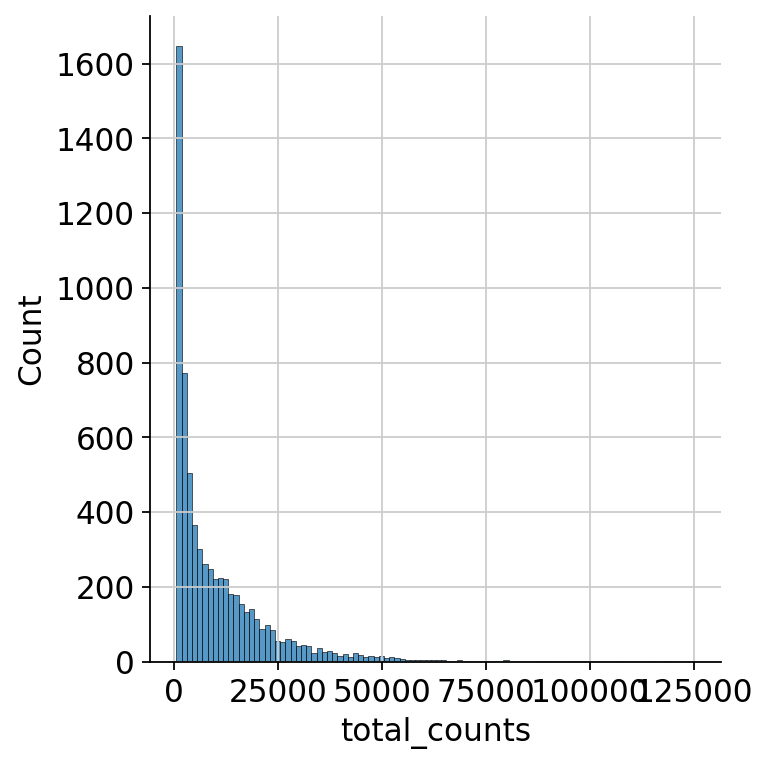

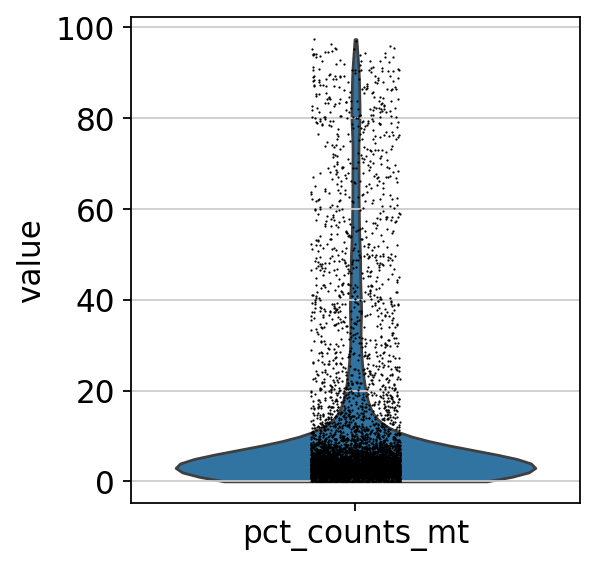

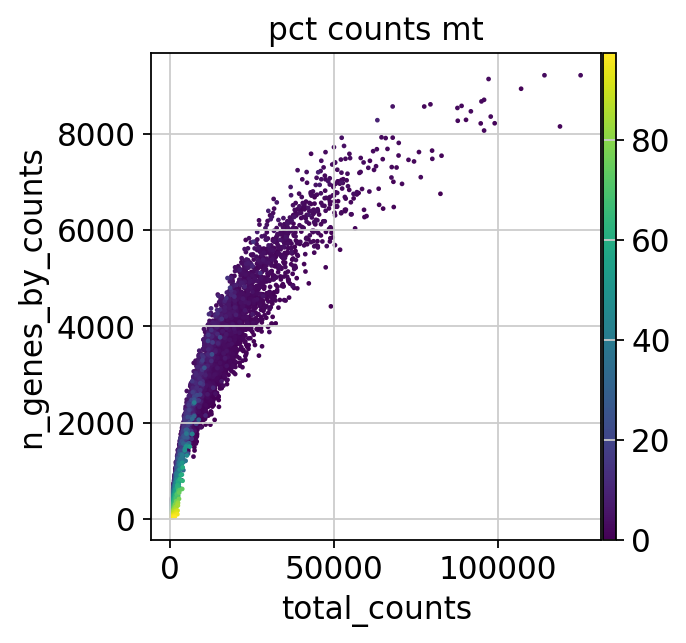

False    5703
True      964
Name: outlier, dtype: int64


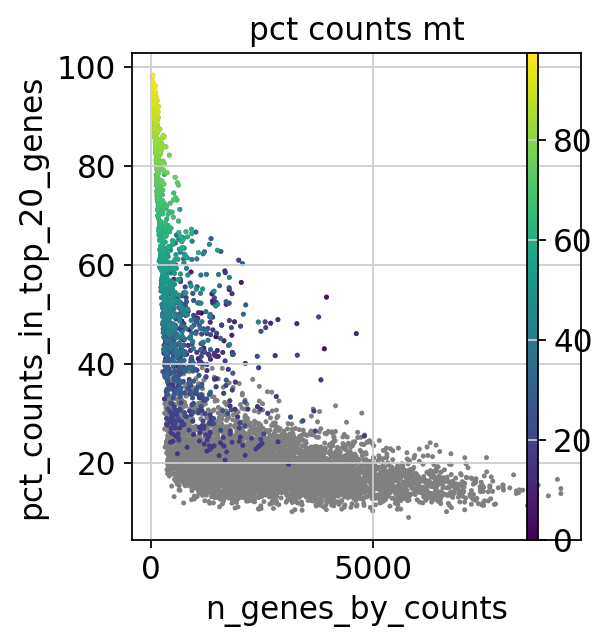

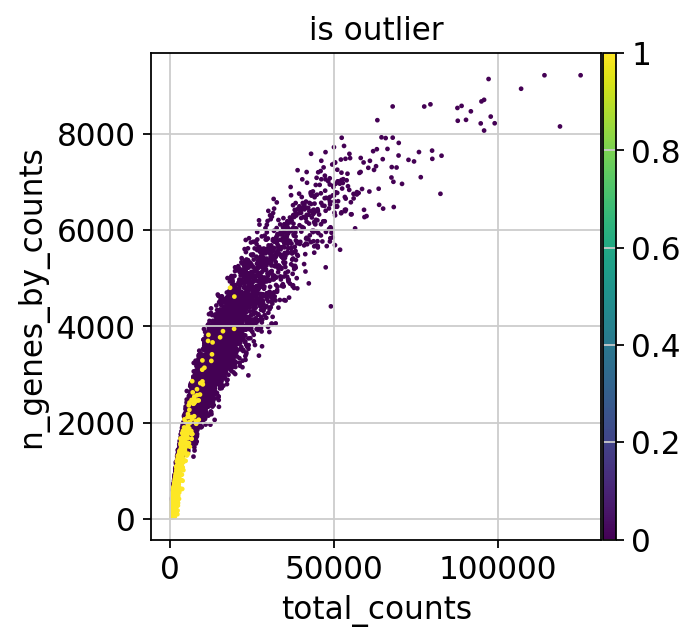

Total number of cells: 6667
Number of cells after filtering of low quality cells: 5432


In [12]:
adata26 = filtering(adata26,"26")

Sample 27 :

In [13]:
adata27 = sc.read_10x_h5(
    filename="sample_27/filtered_feature_bc_matrix.h5")
adata27

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 5945 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [14]:
sum(adata27.X.data)

48523149.0

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


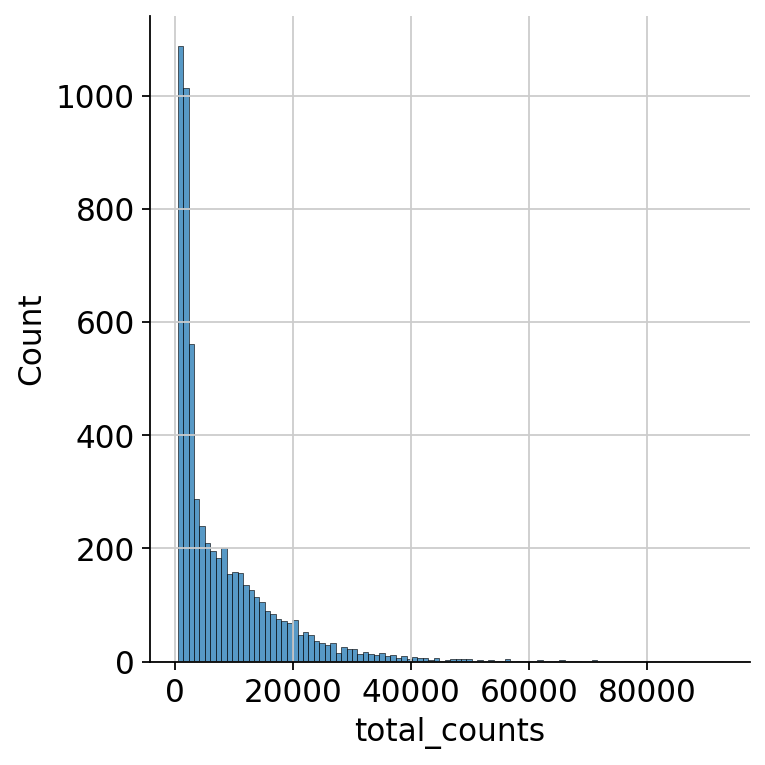

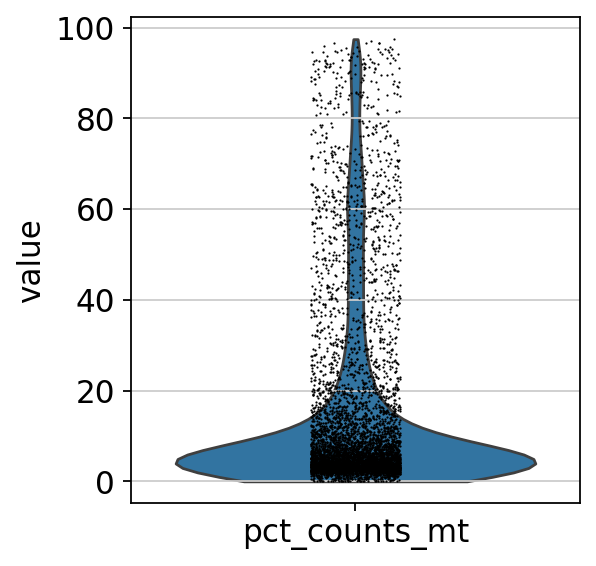

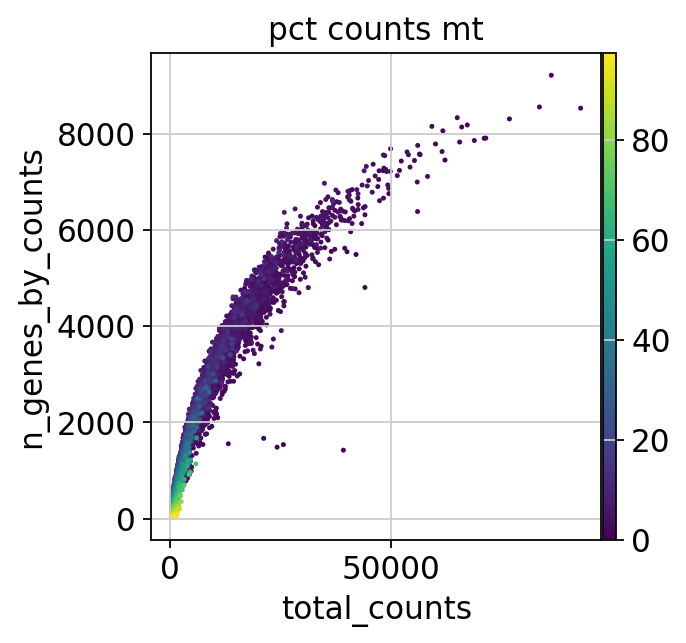

False    5129
True      816
Name: outlier, dtype: int64


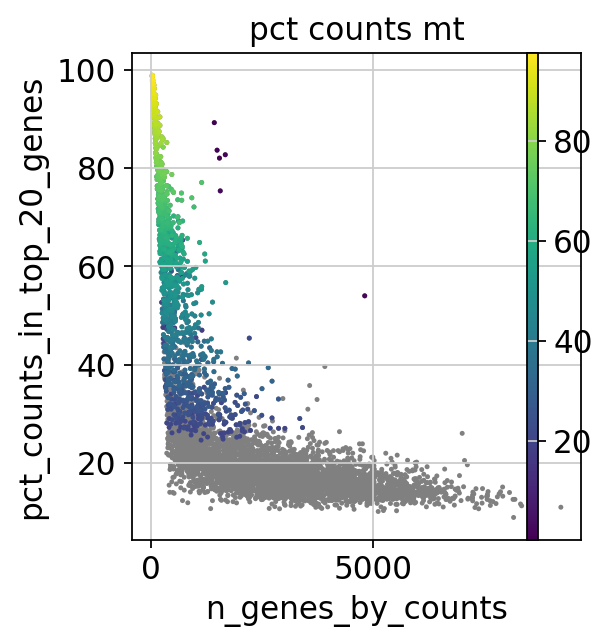

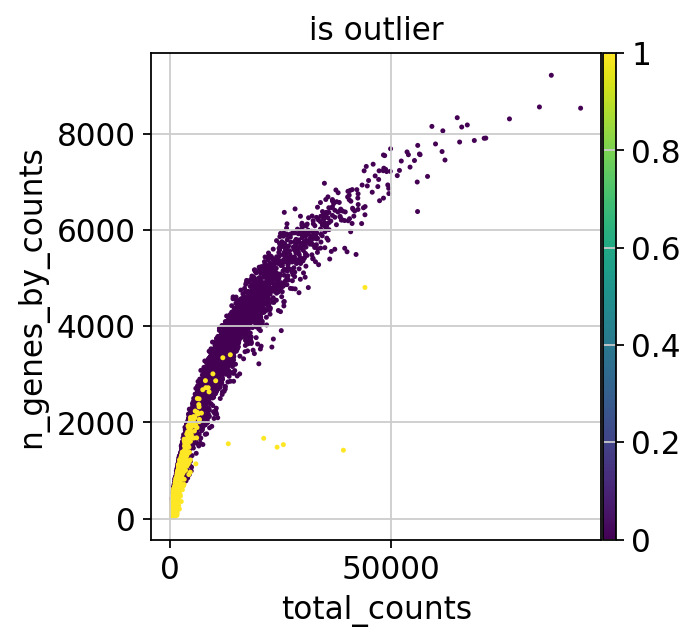

Total number of cells: 5945
Number of cells after filtering of low quality cells: 4721


In [15]:
adata27 = filtering(adata27,"27")

Sample 35

In [16]:
adata35 = sc.read_10x_h5(
    filename="sample_35/filtered_feature_bc_matrix.h5")
adata35

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2317 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [17]:
sum(adata35.X.data)

390544.0

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


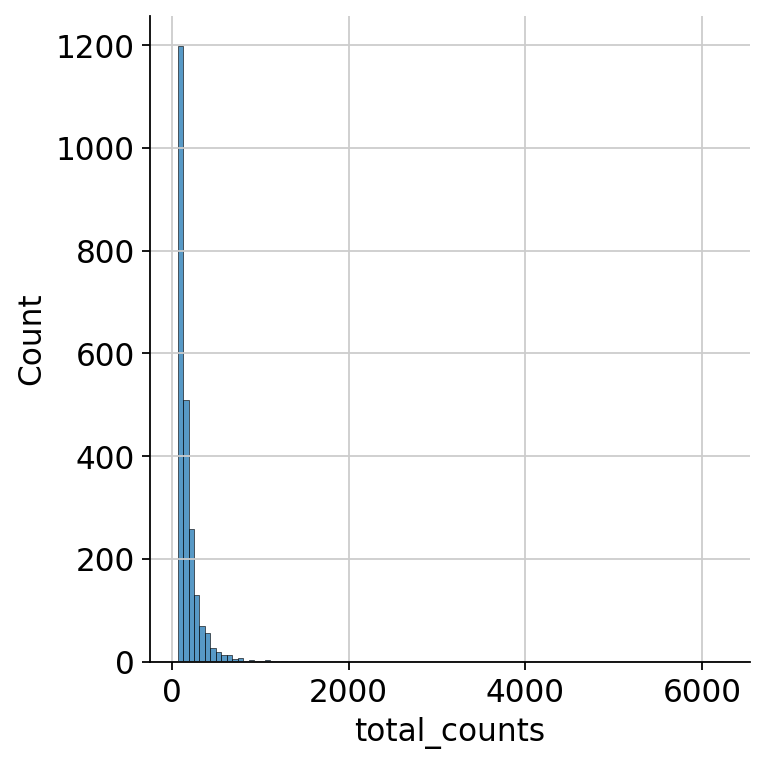

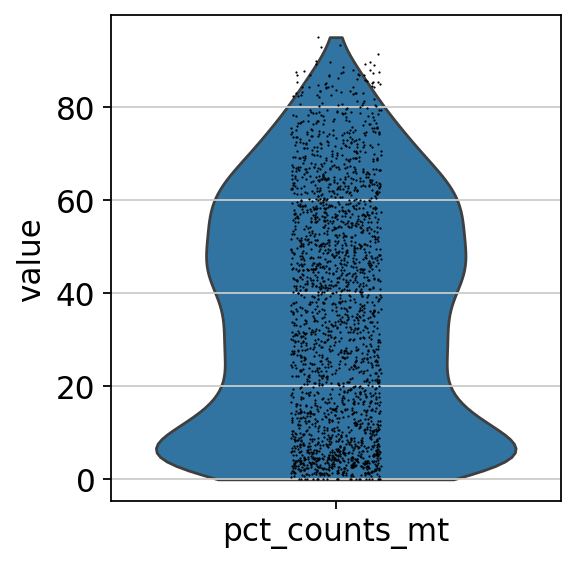

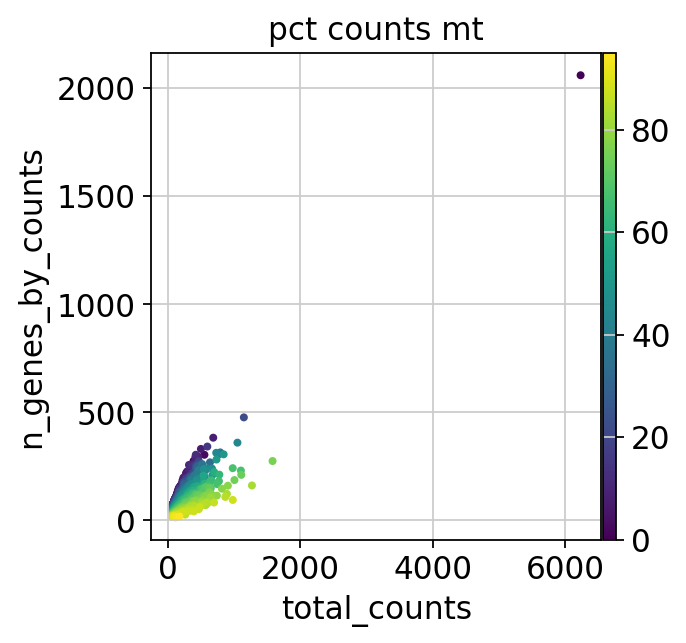

False    2298
True       19
Name: outlier, dtype: int64


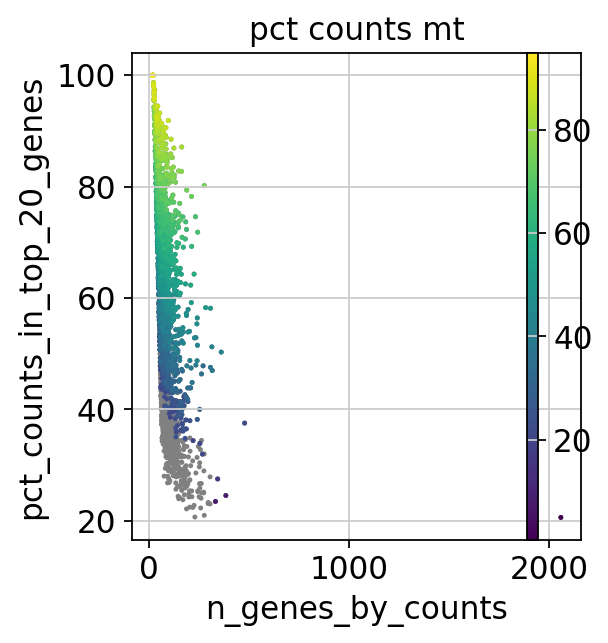

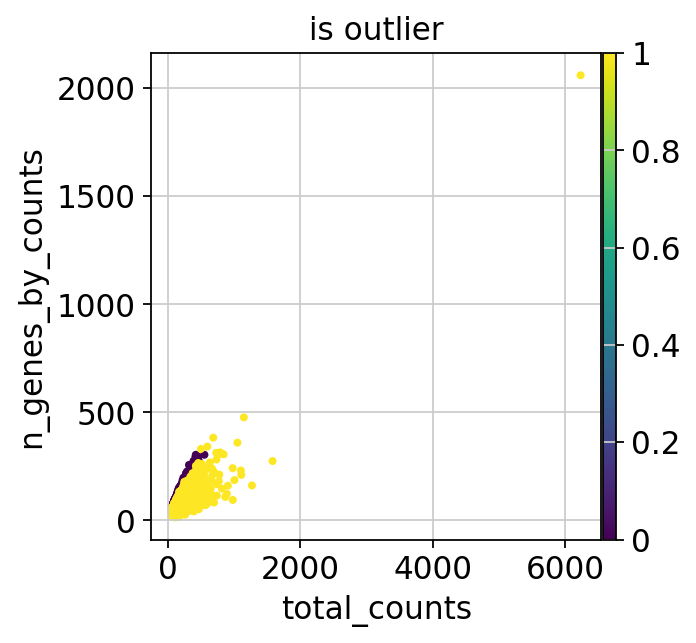

Total number of cells: 2317
Number of cells after filtering of low quality cells: 779


In [18]:
adata35 = filtering(adata35,"35")

Sample 36

In [19]:
adata36 = sc.read_10x_h5(
    filename="sample_36/filtered_feature_bc_matrix.h5")
adata36

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 14061 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [20]:
sum(adata36.X.data)

143441484.0

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


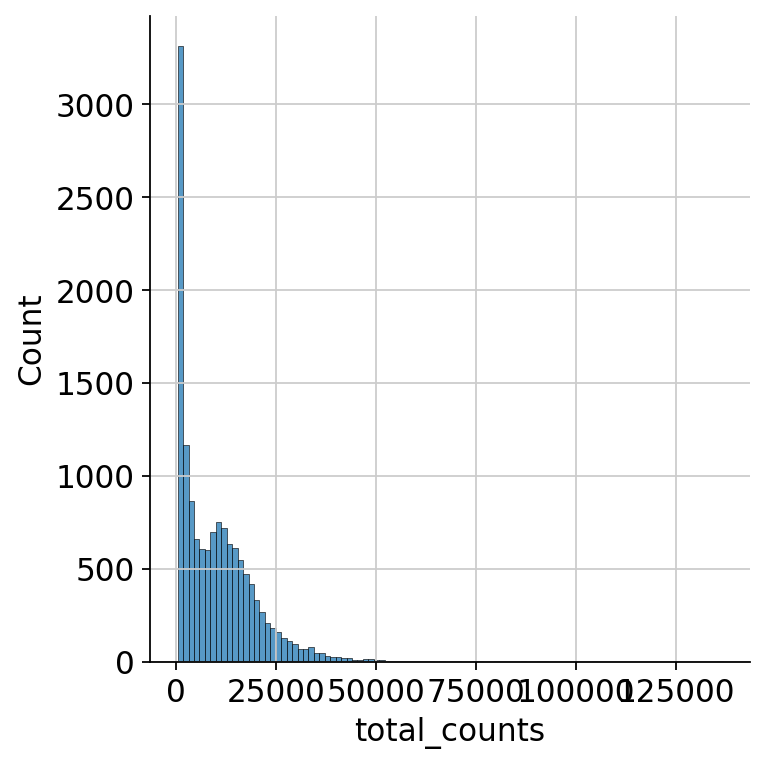

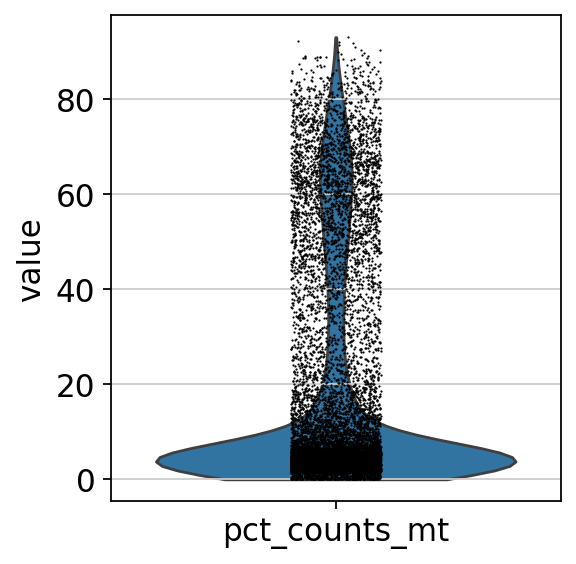

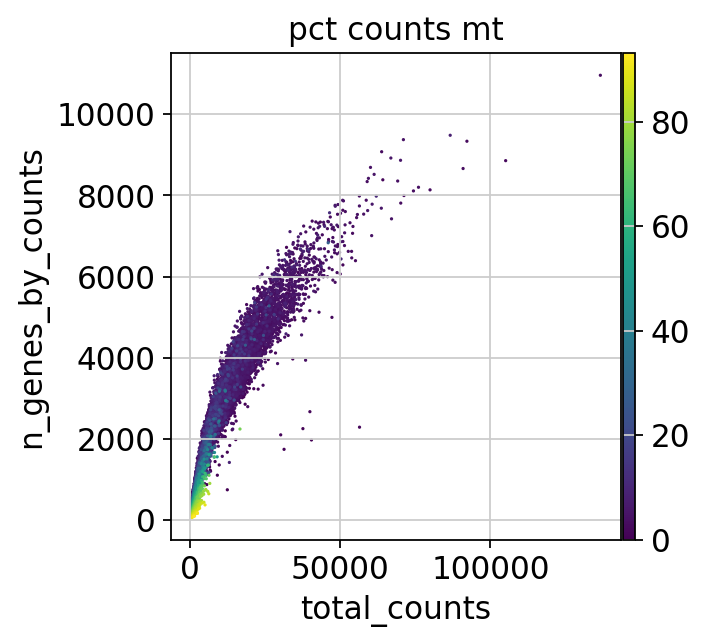

False    10942
True      3119
Name: outlier, dtype: int64


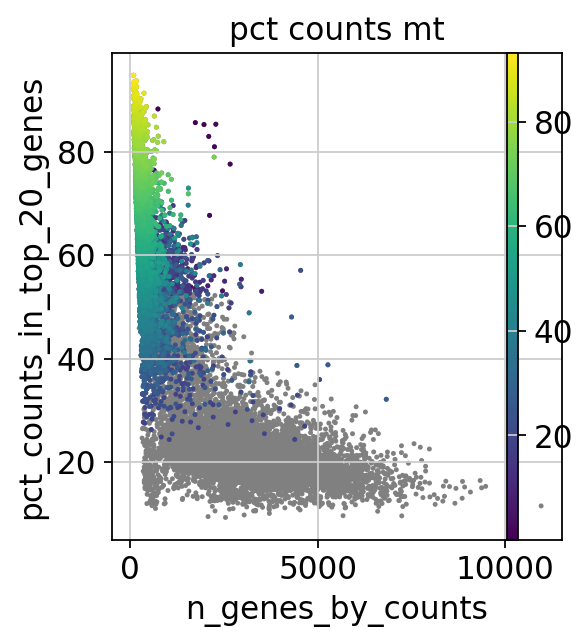

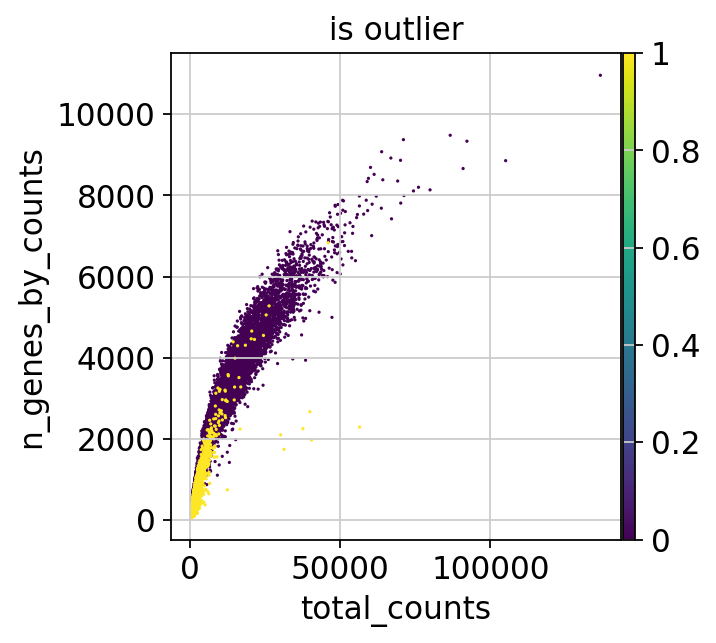

Total number of cells: 14061
Number of cells after filtering of low quality cells: 9927


In [21]:
adata36 = filtering(adata36,"36")

Sample TICP32

In [22]:
adataTICP32 = sc.read_10x_h5(
    filename="sample_TICP32/filtered_feature_bc_matrix.h5")
adataTICP32

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 654 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [23]:
sum(adataTICP32.X.data)

6187332.0

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


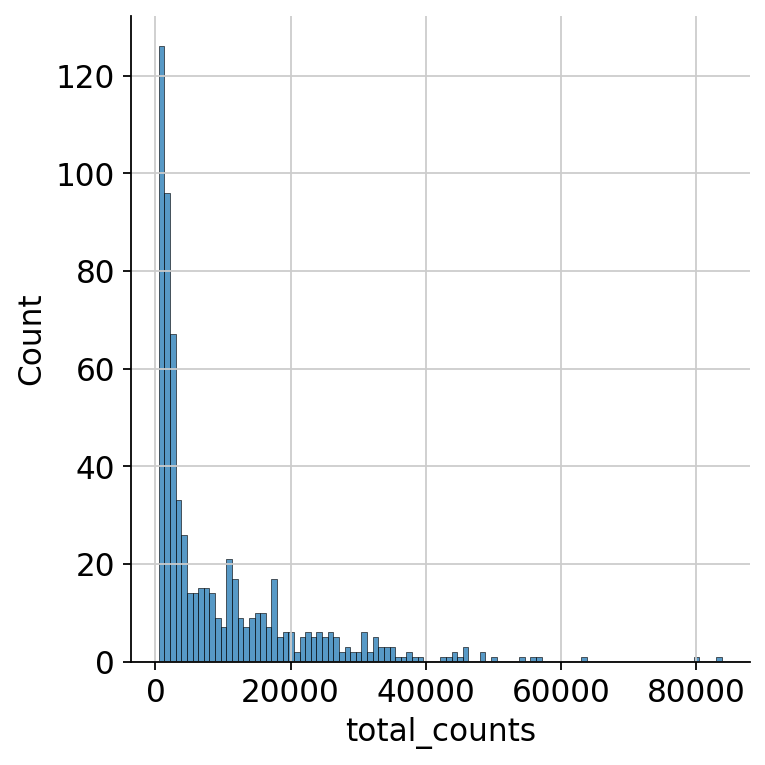

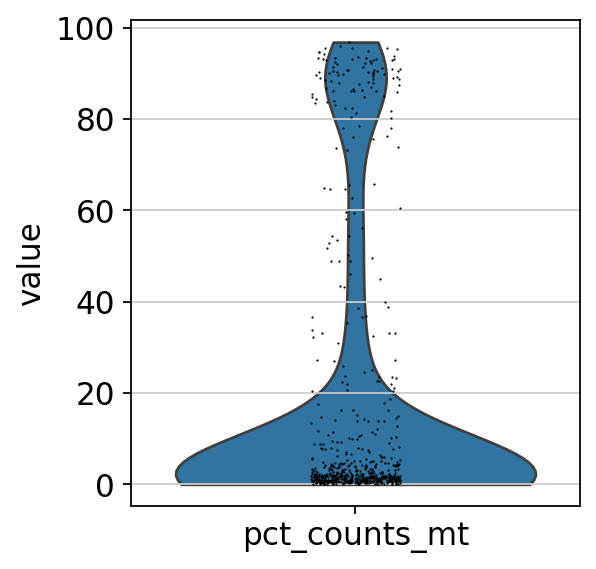

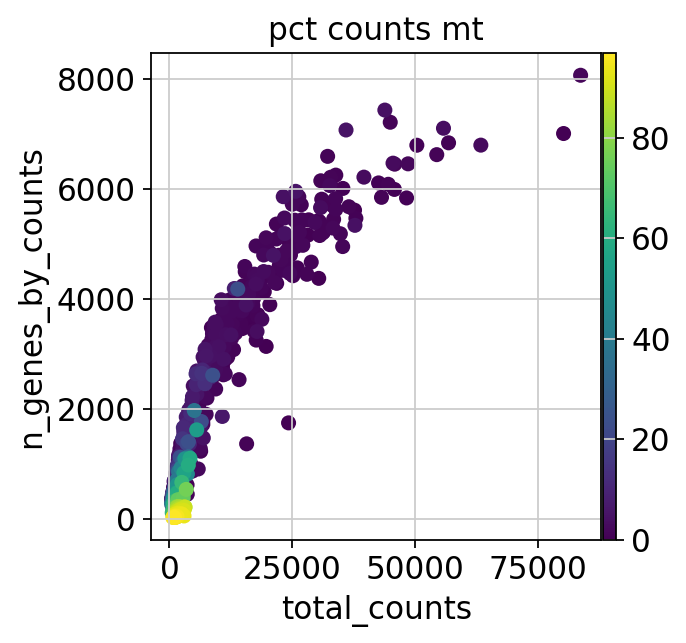

False    528
True     126
Name: outlier, dtype: int64


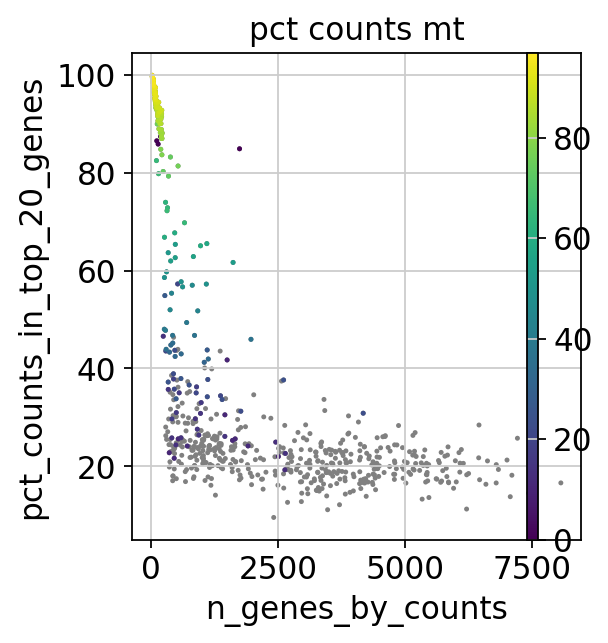

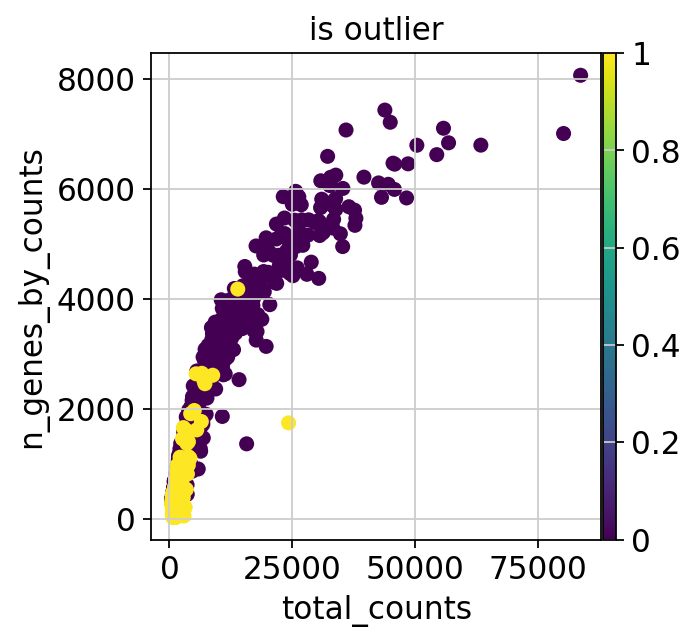

Total number of cells: 654
Number of cells after filtering of low quality cells: 468


In [24]:
adataTICP32 = filtering(adataTICP32,"TICP32")

Data analyses

In [25]:
mt_genes(adata36)

       gene  average_expression
5   MT-ATP6          132.624084
7    MT-ND3          113.842873
3    MT-CO2          110.201614
2    MT-CO1          109.773415
12   MT-CYB           69.045784


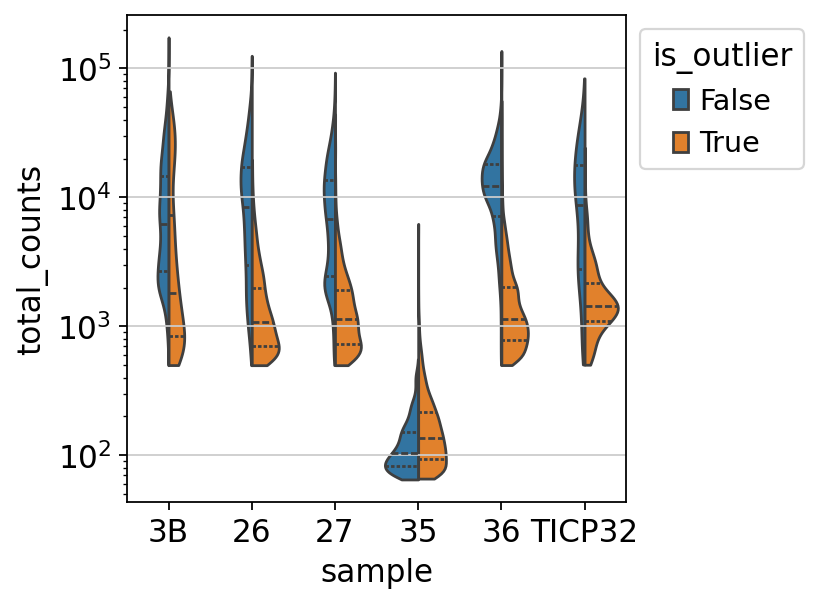

In [26]:
violin_QC_plot(adata3B,adata26,adata27,adata35,adata36,adataTICP32)

In [38]:
adata3B = adata3B[(~adata3B.obs.outlier) & (~adata3B.obs.mt_outlier)].copy()

In [28]:
adata26 = adata26[(~adata26.obs.outlier) & (~adata26.obs.mt_outlier)].copy()

In [29]:
adata27 = adata27[(~adata27.obs.outlier) & (~adata27.obs.mt_outlier)].copy()

In [30]:
adata35 = adata35[(~adata35.obs.outlier) & (~adata35.obs.mt_outlier)].copy()

In [31]:
adata36 = adata36[(~adata36.obs.outlier) & (~adata36.obs.mt_outlier)].copy()

In [32]:
adataTICP32 = adataTICP32[(~adataTICP32.obs.outlier) & (~adataTICP32.obs.mt_outlier)].copy()

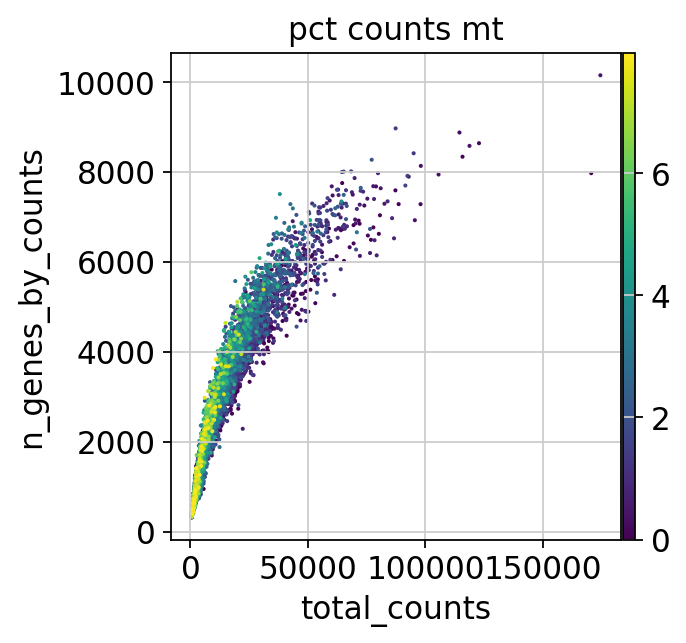

In [39]:
p1_3B = sc.pl.scatter(adata3B, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

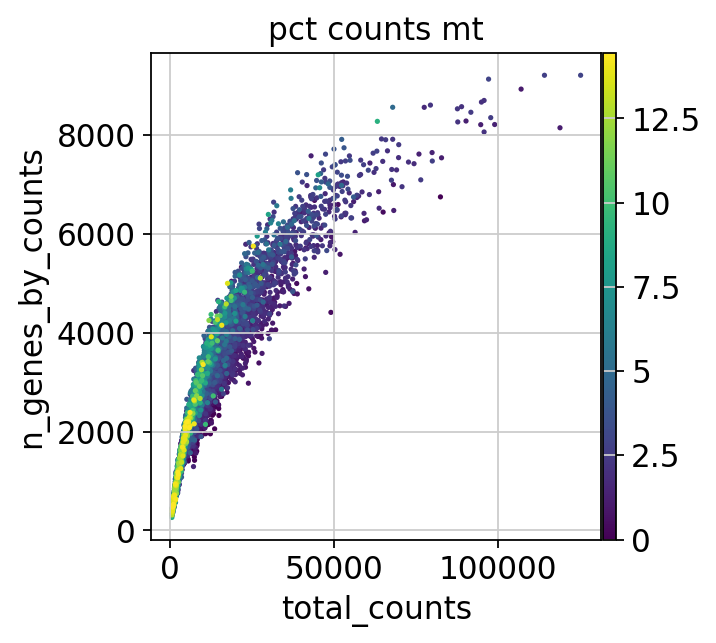

In [34]:
p1_26 = sc.pl.scatter(adata26, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

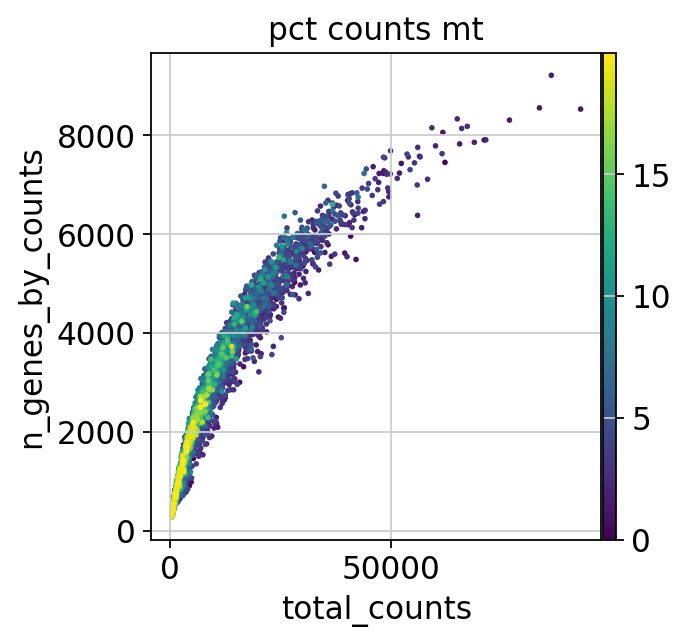

In [35]:
p1_27 = sc.pl.scatter(adata27, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

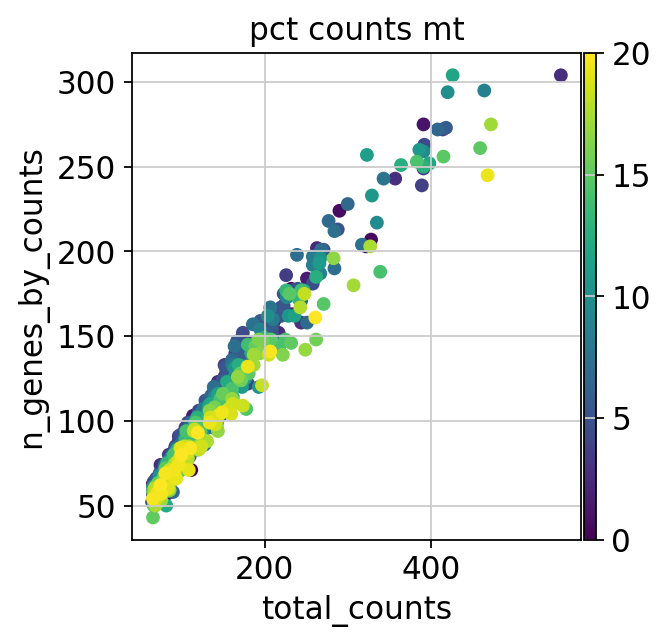

In [36]:
p1_35 = sc.pl.scatter(adata35, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

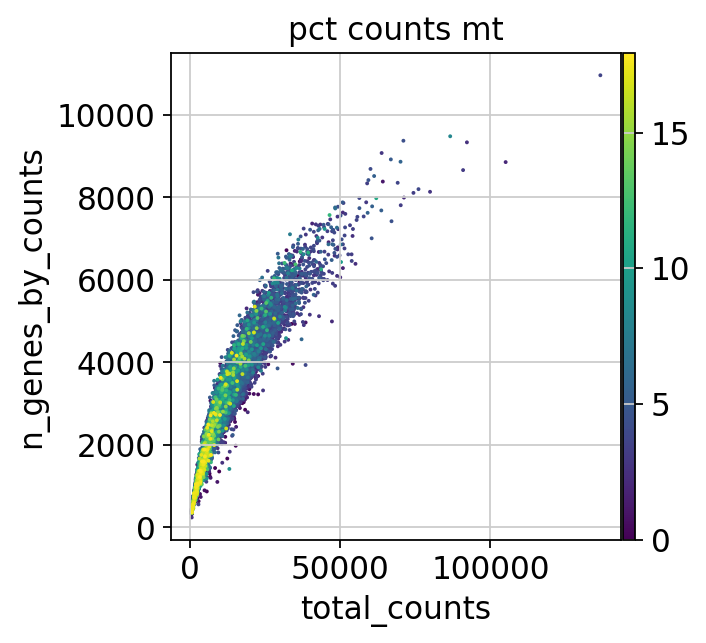

In [37]:
p1_36 = sc.pl.scatter(adata36, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

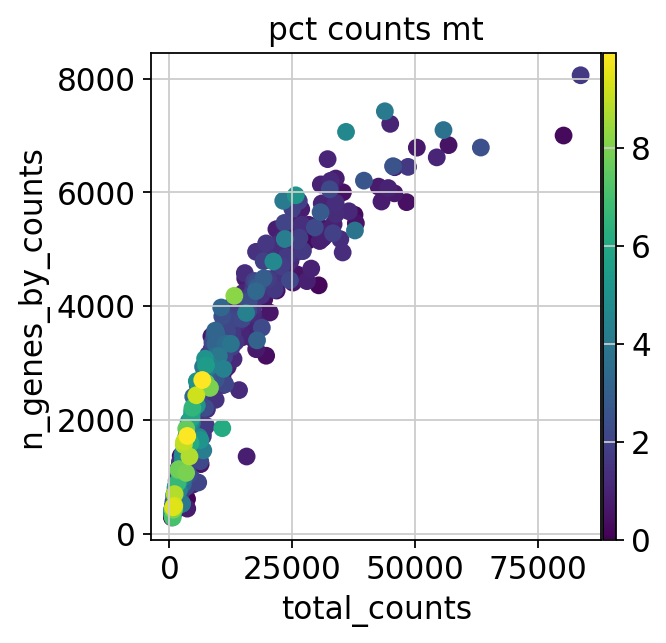

In [38]:
p1_TICP32 = sc.pl.scatter(adataTICP32, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [40]:
sum(adata3B.X.data) #98690529.0

98690529.0

In [40]:
sum(adata26.X.data) #66917353.0

66917353.0

In [41]:
sum(adata27.X.data) #46436880.0

46436880.0

In [42]:
sum(adata35.X.data) #101574.0

101574.0

In [43]:
sum(adata36.X.data) #135935134.0

135935134.0

In [44]:
sum(adataTICP32.X.data) #5813621.0

5813621.0

## Correcting droplet-based rna/ambient rna (the soup)

In [41]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
#anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [42]:
%%R 
#install.packages("SoupX")
library(SoupX)

In [43]:
def soup_R(data,data_tod,genes,cells,soupx_groups):
    
    np.random.seed(0)
    
    with ro.conversion.localconverter(anndata2ri.converter):
        ro.globalenv['data'] = data
        ro.globalenv['data_tod'] = data_tod
        ro.globalenv['genes'] = genes
        ro.globalenv['cells'] = cells
        ro.globalenv['soupx_groups'] = soupx_groups
    
        r_code = """
        set.seed(0)
        
        # specify row and column names of data
        rownames(data) = genes
        colnames(data) = cells
        # ensure correct sparse format for table of counts and table of droplets
        data <- as(data, "sparseMatrix")
        data_tod <- as(data_tod, "sparseMatrix")

        # Generate SoupChannel Object for SoupX 
        sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

        # Add extra meta data to the SoupChannel object
        soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
        sc = setSoupProfile(sc, soupProf)
        # Set cluster information in SoupChannel
        sc = setClusters(sc, soupx_groups)

        # Estimate contamination fraction
        sc  = autoEstCont(sc, doPlot=FALSE)
        # Infer corrected table of counts and rount to integer
        out = adjustCounts(sc, roundToInt = TRUE)
        """
        ro.r(r_code)
        
        with ro.conversion.localconverter(anndata2ri.converter):
    
            out = ro.globalenv['out']
    
    return out
    

In [44]:
def ambient_rna_correction(adata,adata_raw):
    
    np.random.seed(0)
    
    adata_pp = adata.copy()
    sc.pp.normalize_per_cell(adata_pp)
    sc.pp.log1p(adata_pp)
    
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added="soupx_groups")

    # Preprocess variables for SoupX
    soupx_groups = adata_pp.obs["soupx_groups"]
        
    cells = adata.obs_names
    genes = adata.var_names
    data = adata.X.T
    
    adata_raw.var_names_make_unique()
    data_tod = adata_raw.X.T
    
    out = soup_R(data,data_tod,genes,cells,soupx_groups)
    
    adata.layers["counts"] = adata.X
    adata.layers["soupX_counts"] = out.T
    adata.X = adata.layers["soupX_counts"]

    #print(sum(adata.X.data))
    
    print(f"Total number of genes: {adata.n_vars}") 
    print(f"Total number of reads: {sum(adata.X.data)}") 

    # Min 20 cells - filters out 0 count genes; see if we want to change this for integration
    #sc.pp.filter_genes(adata, min_cells=20)
    print(f"Number of genes after ambient RNA correction: {adata.n_vars}") 
    print(f"Total number of reads: {sum(adata.X.data)}") 
    print(sum(adata.X.data))
    
    return adata
        

In [45]:
adata3B_raw = sc.read_10x_h5(
    filename="sample_3B/raw_feature_bc_matrix.h5")

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [50]:
adata26_raw = sc.read_10x_h5(
    filename="sample_26/raw_feature_bc_matrix.h5")

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [51]:
adata27_raw = sc.read_10x_h5(
    filename="sample_27/raw_feature_bc_matrix.h5")

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [52]:
adata35_raw = sc.read_10x_h5(
    filename="sample_35/raw_feature_bc_matrix.h5")

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [53]:
adata36_raw = sc.read_10x_h5(
    filename="sample_36/raw_feature_bc_matrix.h5")

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [54]:
adataTICP32_raw = sc.read_10x_h5(
    filename="sample_TICP32/raw_feature_bc_matrix.h5")

/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mangel/miniconda3/envs/meso2_conda_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [46]:
adata3B = ambient_rna_correction(adata3B,adata3B_raw)

Total number of genes: 36601
Total number of reads: 98690529.0
Number of genes after cell filter: 17710
Total number of reads: 98690529.0
97246657.0


In [56]:
adata26 = ambient_rna_correction(adata26,adata26_raw)

Total number of genes: 36601
Number of genes after cell filter: 16759
66199046.0


In [57]:
adata27 = ambient_rna_correction(adata27,adata27_raw)

Total number of genes: 36601
Number of genes after cell filter: 15568
45924445.0


In [58]:
adata35 = ambient_rna_correction(adata35,adata35_raw)

Total number of genes: 36601
Number of genes after cell filter: 441
47684.0


In [59]:
adata36 = ambient_rna_correction(adata36,adata36_raw)

Total number of genes: 36601
Number of genes after cell filter: 19964
131387377.0


In [60]:
adataTICP32 = ambient_rna_correction(adataTICP32,adataTICP32_raw)

Total number of genes: 36601
Number of genes after cell filter: 11766
5686205.0


## Doublet detection

In [48]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [47]:
def doublet_detection(adata):
    
    np.random.seed(0)
    
    data_mat = adata.X.T
    
    with ro.conversion.localconverter(anndata2ri.converter):
        ro.globalenv['data_mat'] = data_mat
    
        r_code = """
        set.seed(0)
        sce = scDblFinder(
            SingleCellExperiment(
                list(counts=data_mat),
            ) 
        )
        doublet_score = sce$scDblFinder.score
        doublet_class = sce$scDblFinder.class
        """
        ro.r(r_code)
        
        with ro.conversion.localconverter(anndata2ri.converter):
    
            doublet_score = ro.globalenv['doublet_score']
            doublet_class = ro.globalenv['doublet_class']
    
    adata.obs["scDblFinder_score"] = doublet_score
    adata.obs["scDblFinder_class"] = doublet_class
    print(adata.obs.scDblFinder_class.value_counts())

    print(f"Total number of reads: {sum(adata.X.data)}") 
    
    return adata
    

In [49]:
adata3B = doublet_detection(adata3B)

singlet    7916
doublet    1017
Name: scDblFinder_class, dtype: int64
97246657.0
Total number of reads: 98690529.0


In [54]:
sum(adata3B.X.sum(axis=1).A1)

97246657.0

In [64]:
adata26 = doublet_detection(adata26)

singlet    4922
doublet     510
Name: scDblFinder_class, dtype: int64
66199046.0


In [65]:
adata27 = doublet_detection(adata27)

singlet    4317
doublet     404
Name: scDblFinder_class, dtype: int64
45924445.0


In [66]:
adata35 = doublet_detection(adata35)

singlet    750
doublet     29
Name: scDblFinder_class, dtype: int64
47684.0


In [67]:
adata36 = doublet_detection(adata36)

singlet    8949
doublet     978
Name: scDblFinder_class, dtype: int64
131387377.0


In [68]:
adataTICP32 = doublet_detection(adataTICP32)

singlet    453
doublet     15
Name: scDblFinder_class, dtype: int64
5686205.0


In [69]:
adata3B.write("sample_3B/sample3B_quality_control.h5ad")

In [70]:
adata26.write("sample_26/sample26_quality_control.h5ad")

In [71]:
adata27.write("sample_27/sample27_quality_control.h5ad")

In [72]:
adata35.write("sample_35/sample35_quality_control.h5ad")

In [73]:
adata36.write("sample_36/sample36_quality_control.h5ad")

In [74]:
adataTICP32.write("sample_TICP32/sampleTICP32_quality_control.h5ad")

For intronic content analysis: get adata.obs for each sample to identify damaged cells & empty droplets

In [ ]:
adata = sc.read_10x_h5(
    filename="sample_36/filtered_feature_bc_matrix.h5")

sample = "36"

np.random.seed(0)

adata.var_names_make_unique()

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(
adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

#print(np.median(adata.obs["total_counts"]))
#print(np.median(adata.obs["n_genes_by_counts"]))
#print(np.median(adata.obs["pct_counts_in_top_20_genes"]))
adata.obs["outlier"] = (
    check_outlier(adata, "log1p_total_counts", 5)
    | check_outlier(adata, "log1p_n_genes_by_counts", 5)
    | check_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print(adata.obs.outlier.value_counts())

#adata.obs["mt_outlier"] = check_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 20)
adata.obs["mt_outlier"] = check_outlier(adata, "pct_counts_mt", 5) | (adata.obs["pct_counts_mt"] > 20)

adata.obs.mt_outlier.value_counts()

is_outlier = []
for i in range(adata.obs.shape[0]):
    is_outlier.append(max(adata.obs.outlier[i],adata.obs.mt_outlier[i]))
    
adata.obs["is_outlier"] = is_outlier

# Define dot size for all plot parts
s=20
# Plot all cells as background
ax=sc.pl.scatter(adata, "n_genes_by_counts", "pct_counts_in_top_20_genes", show=False,size=s)
# Plot ontop expression of a single cell group by subsetting adata
p = sc.pl.scatter(adata[adata.obs.is_outlier==True,:], "n_genes_by_counts", "pct_counts_in_top_20_genes", color='pct_counts_mt',ax=ax,size=s)
# Show the plots
plt.show()

adata.obs['sample']=sample

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color='is_outlier')

print(f"Total number of cells: {adata.n_obs}")
print(f"Total number of reads: {sum(adata.X.data)}")

adata.obs.to_csv("sample_36/obs36.csv")
#adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
#adata = adata[~adata.obs.outlier].copy()

#print(f"Number of cells after filtering of low quality cells: {adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].n_obs}")
#print(f"Number of reads after filtering of low quality cells: {sum(adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].X.data)}")
